In [21]:
### Si données locales
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

In [22]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)+r.means
mae(m.svd2[i.test.b], m.na[i.test.b])
    }


In [23]:
Mode <- function(x) {
  ux <- unique(x[x>0])
  ux[which.max(tabulate(match(x[x>0], ux)))]
}

In [24]:
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
to.plot <- c()
set.seed(1)
cv.b <- c()
ptm <- proc.time()
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
    
u.mode <- apply(m.train,1,FUN=Mode)
item.mode <-apply(m.train,2,FUN=Mode)
m.expect.mode <- outer( u.mode,item.mode, FUN="+")/2
m.train.na[m.train==0] <-m.expect.mode[m.train==0]
r.means <-apply(m.train,1,FUN=Mode)
m.train.na[!is.finite(m.train.na)]<- r.means
r.means <- apply(m.train,1,FUN=Mode)
cv.b <- c(cv.b,mae(m.train.na[i.test.b], m.na[i.test.b]))
m.train.na <- m.train.na-r.means
m.svd <- svd(m.train.na)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }
(proc.time()-ptm)/5


   user  system elapsed 
 36.474   0.222  36.788 

In [25]:
to.plot<-apply(to.plot,2,unlist)

In [26]:
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
avg
x <- 1:length(avg)

[1] 0.8169146 0.7791716 0.7723608 0.7678271 0.7663901 0.7648941 0.7639587
 [8] 0.7629005 0.7624316 0.7624713 0.7628541 0.7627624 0.7630311 0.7633890
[15] 0.7636700 0.7640462 0.7646696 0.7649643 0.7651780 0.7656455 0.7659639
[22] 0.7663499

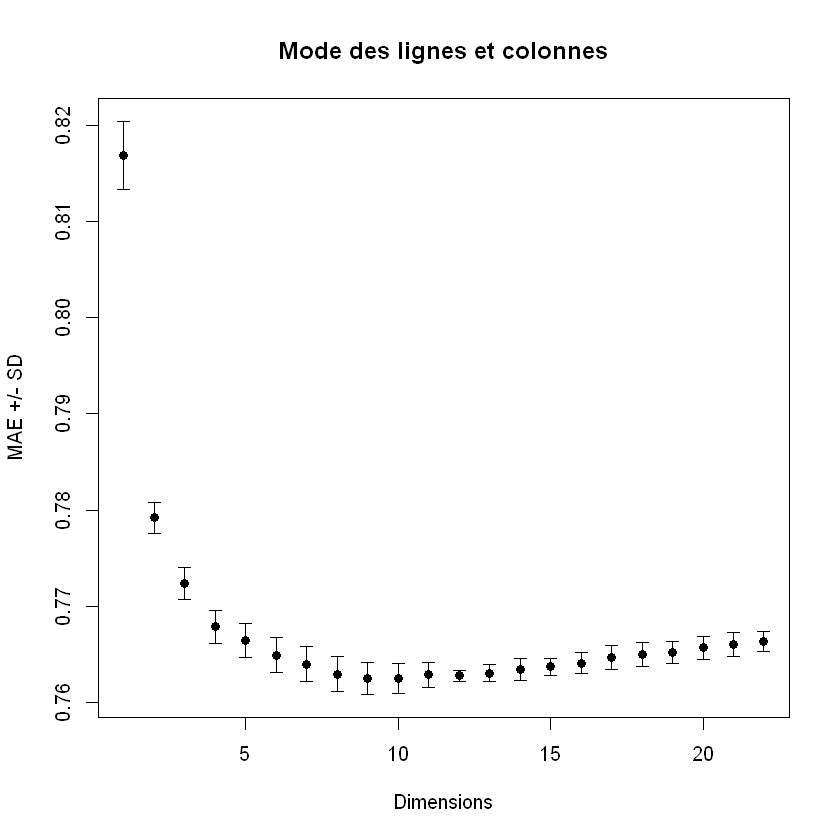

In [27]:
plot(x,avg,ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Dimensions", ylab="MAE +/- SD",
    main="Mode des lignes et colonnes"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [32]:
mean(cv.b)

[1] 0.7840586

In [29]:
avg

[1] 0.8169146 0.7791716 0.7723608 0.7678271 0.7663901 0.7648941 0.7639587
 [8] 0.7629005 0.7624316 0.7624713 0.7628541 0.7627624 0.7630311 0.7633890
[15] 0.7636700 0.7640462 0.7646696 0.7649643 0.7651780 0.7656455 0.7659639
[22] 0.7663499

In [30]:
write.table(avg, file="out/total/mode.csv",sep="")